In [95]:
import crispr_assembler as  ca
import numpy as np

import matplotlib.pyplot as plt

import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.ensemble import gradient_boosting

In [3]:
from sklearn.metrics import f1_score

In [98]:
import os, sys
from multiprocessing import Pool

In [5]:
after_path = "../../data/repeat_to_repeat_1000/after/"
before_path = "../../data/repeat_to_repeat_1000/before/"

after_names = sorted(os.listdir(after_path))
before_names = sorted(os.listdir(before_path))

In [6]:
before_graphs = [np.load(before_path + x) for x in before_names]
after_graphs = [np.load(after_path + x) for x in after_names]

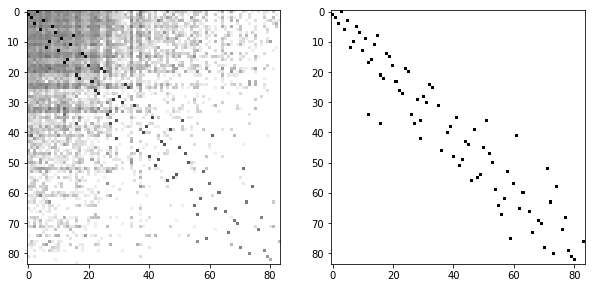

In [107]:
idx = 0

plot_agr, order = ca.rearange(after_graphs[idx])
plot_bgr, order = ca.rearange(before_graphs[idx], order)

ca.plot_grs(plot_agr, 
           prepare_y(plot_bgr).reshape(plot_bgr.shape),
           log = 1)

## embs variants

In [13]:
gr = plot_agr.astype(int)

In [14]:
gr[0]

array([  145,   124,   104, 32248,   212,    46,   213,   240,    49,
         117,   160,   130,    89,   130,    58,    90,   115,   163,
          49,    46,    19,    65,    50,    87,    11,    24,    65,
          51,     6,    33,     5,     3,     0,     5,    63,     0,
           3,   151,    22,     9,     4,     1,    10,     0,     1,
           2,    82,     2,     5,    15,     9,    13,     8,     1,
           1,    16,    10,    11,     1,    13,     0,     0,     0,
           2,    27,     0,     2,    36,     1,     0,     0,     5,
           1,     0,     1,     0,     2,     0,     2,     2,     0,
           9,     0,     0])

In [24]:
np.where(np.argsort(gr[0]) == 20)[0][0] / gr.shape[0]

0.5952380952380952

In [72]:
def get_percentiles(gr, i, j):
    return [np.where(np.argsort(gr[i]) == j)[0][0] / (gr.shape[0] - 1), \
            np.where(np.argsort(gr[:, j]) == i)[0][0] / (gr.shape[0] - 1)]

In [73]:
def get_ratios(gr, i, j):
    return [gr[i, j] / max(1, gr[i].sum()), gr[i, j] / max(1, gr[:, j].sum())]

In [83]:
def get_median_ratios(gr, i, j):
    return [np.log(gr[i, j] / max(1, np.median(gr[i])) + 1), np.log(gr[i, j] / max(1, np.median(gr[:, j])) + 1)] 

In [91]:
def prepare_embs(gr):
    embs = []
    
    for i in range(gr.shape[0]):
        for j in range(gr.shape[1]):
            emb = []
            emb.extend(get_percentiles(gr, i, j))
            emb.extend(get_ratios(gr, i, j))
            emb.extend(get_median_ratios(gr, i, j))
            embs.append(np.array(emb))
            
    return np.stack(embs) 
            

In [104]:
def prepare_y(gr):
    return (gr.flatten() > 0).astype(int)

In [99]:
p = Pool(8)

In [100]:
all_embs = p.map(prepare_embs, after_graphs)

In [108]:
ys = [prepare_y(gr) for gr in before_graphs]

In [101]:
import pickle

In [102]:
pickle.dump(all_embs, open("../../data/repeat_to_repeat_1000/embs", 'wb'))

In [116]:
train_set = np.concatenate(all_embs[:800])
test_set = np.concatenate(all_embs[800:])

train_y = np.concatenate(ys[:800])
test_y = np.concatenate(ys[800:])

In [111]:
gb = gradient_boosting.GradientBoostingClassifier()

In [118]:
gb.fit(train_set, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [119]:
pickle.dump(gb, open("./gb_rep_to_rep" , 'wb'))

In [120]:
pred = gb.predict(test_set)

In [121]:
f1_score(test_y, pred)

0.9889522272108157